## Introduction to the dataset

- World Health Organization has  estimated 12 million deaths occur worldwide, every year due to Heart diseases.

- Half the deaths in the United States and other developed countries are due to cardio vascular diseases. 

- The early prognosis of cardiovascular diseases can aid in making decisions on lifestyle changes in high risk patients and in turn reduce the complications.

- This research intends to pinpoint the most relevant/risk factors of heart disease as well as predict the overall risk using logistic regression.


In [84]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.tools import add_constant as ac
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,  mean_squared_error, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, Binarizer
sc = StandardScaler()
le = LabelEncoder()

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
rfr = RandomForestRegressor()
rfc = RandomForestClassifier()
import warnings
warnings.filterwarnings('ignore')

In [85]:
# Test
dfp = pd.read_csv('US_Heart_Patients.csv')
dfp.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [86]:
dfp.shape

(4240, 16)

In [87]:
target_var = 'TenYearCHD'

In [88]:
dfp.describe().T

,count,mean,std,min,25%,50%,75%,max
male,4240.0,0.429245,0.495027,0.00,0.00,0.0,1.00,1.0
age,4240.0,49.580189,8.572942,32.00,42.00,49.0,56.00,70.0
education,4135.0,1.979444,1.019791,1.00,1.00,2.0,3.00,4.0
currentSmoker,4240.0,0.494104,0.500024,0.00,0.00,0.0,1.00,1.0
cigsPerDay,4211.0,9.005937,11.922462,0.00,0.00,0.0,20.00,70.0
BPMeds,4187.0,0.029615,0.169544,0.00,0.00,0.0,0.00,1.0
prevalentStroke,4240.0,0.005896,0.076569,0.00,0.00,0.0,0.00,1.0
prevalentHyp,4240.0,0.310613,0.462799,0.00,0.00,0.0,1.00,1.0
diabetes,4240.0,0.025708,0.158280,0.00,0.00,0.0,0.00,1.0
totChol,4190.0,236.699523,44.591284,107.00,206.00,234.0,263.00,696.0


In [89]:
def cm_data(cm):
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    print("Sensitivity: ", tp/(tp+fn))
    print("Specificity: ",tn/(tn+fp))
    print("Precision: ", tp/(tp+fp))
    print("Accuracy: ", (tp+tn)/(tp+tn+fp+fn))

In [90]:
def check_accuracy(test, pred, conf_mat = 'no'):
    acc = accuracy_score(test, pred)
    if conf_mat == 'yes':
        cm = confusion_matrix(test, pred)
        cm_df = pd.DataFrame(cm, columns=['Pred: 0', 'Pred: 1'], index = ['Obs: 0', 'Obs: 1'])
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm_df, annot=True, fmt='d')
        plt.show()
        cm_data(cm)
    return acc
    

In [91]:
def grid_search(model, params, df):
    x_train, x_test, y_train, y_test = split_data(df)
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    grid_mod = GridSearchCV(model, param_grid=params, cv = 10, n_jobs=-1, refit=True)
    grid_mod.fit(x_train, y_train)

    best_estimator = grid_mod.best_estimator_

    y_pred = grid_mod.predict(x_test)
    acc = check_accuracy(y_test, y_pred, conf_mat = 'yes')
    # return acc

In [92]:
def split_data(df, y = target_var):
    x = df.loc[:, df.columns != y]
    y = df.loc[:, y]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)
    # x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size = 0.2, random_state = 123)

    return x_train, x_test, y_train, y_test

###  EDA and Feature Engineering

#### Univariate Analysis

In [93]:
# Caonverting object and numerical to category

to_be_cat = ['male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']
dfp[to_be_cat]= dfp[to_be_cat].astype('category')
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   male             4240 non-null   category
 1   age              4240 non-null   int64   
 2   education        4135 non-null   category
 3   currentSmoker    4240 non-null   category
 4   cigsPerDay       4211 non-null   float64 
 5   BPMeds           4187 non-null   category
 6   prevalentStroke  4240 non-null   category
 7   prevalentHyp     4240 non-null   category
 8   diabetes         4240 non-null   category
 9   totChol          4190 non-null   float64 
 10  sysBP            4240 non-null   float64 
 11  diaBP            4240 non-null   float64 
 12  BMI              4221 non-null   float64 
 13  heartRate        4239 non-null   float64 
 14  glucose          3852 non-null   float64 
 15  TenYearCHD       4240 non-null   category
dtypes: category(8), float64(7), int64(1)
memor

In [94]:
not_to_plot = [] # contains column names which are not to be plotted. In this case we have none.
rand_color = ['red', 'blue', 'green']

In [95]:
dfp.TenYearCHD.replace(to_replace={1: 'Yes', 0:'No'}, inplace=True)
dfp.TenYearCHD.head()
# Replacing values just for plotting purposes.

0     No
1     No
2     No
3    Yes
4     No
Name: TenYearCHD, dtype: category
Categories (2, object): ['No', 'Yes']

In [96]:
def univariate(df, rows = 4, cols = 4):
    fig=plt.figure(figsize=(20,20))
    for j, i in enumerate(df.columns):
        ax=fig.add_subplot(rows,cols,j+1)
        if i in df.select_dtypes(['category']):
            sns.countplot(x= i, data = df, ax=ax)
        if i in df.select_dtypes(['int', 'float64']):
            sns.distplot(x = df[i], ax=ax, color=np.random.choice(rand_color))
    fig.tight_layout() 
    plt.show()

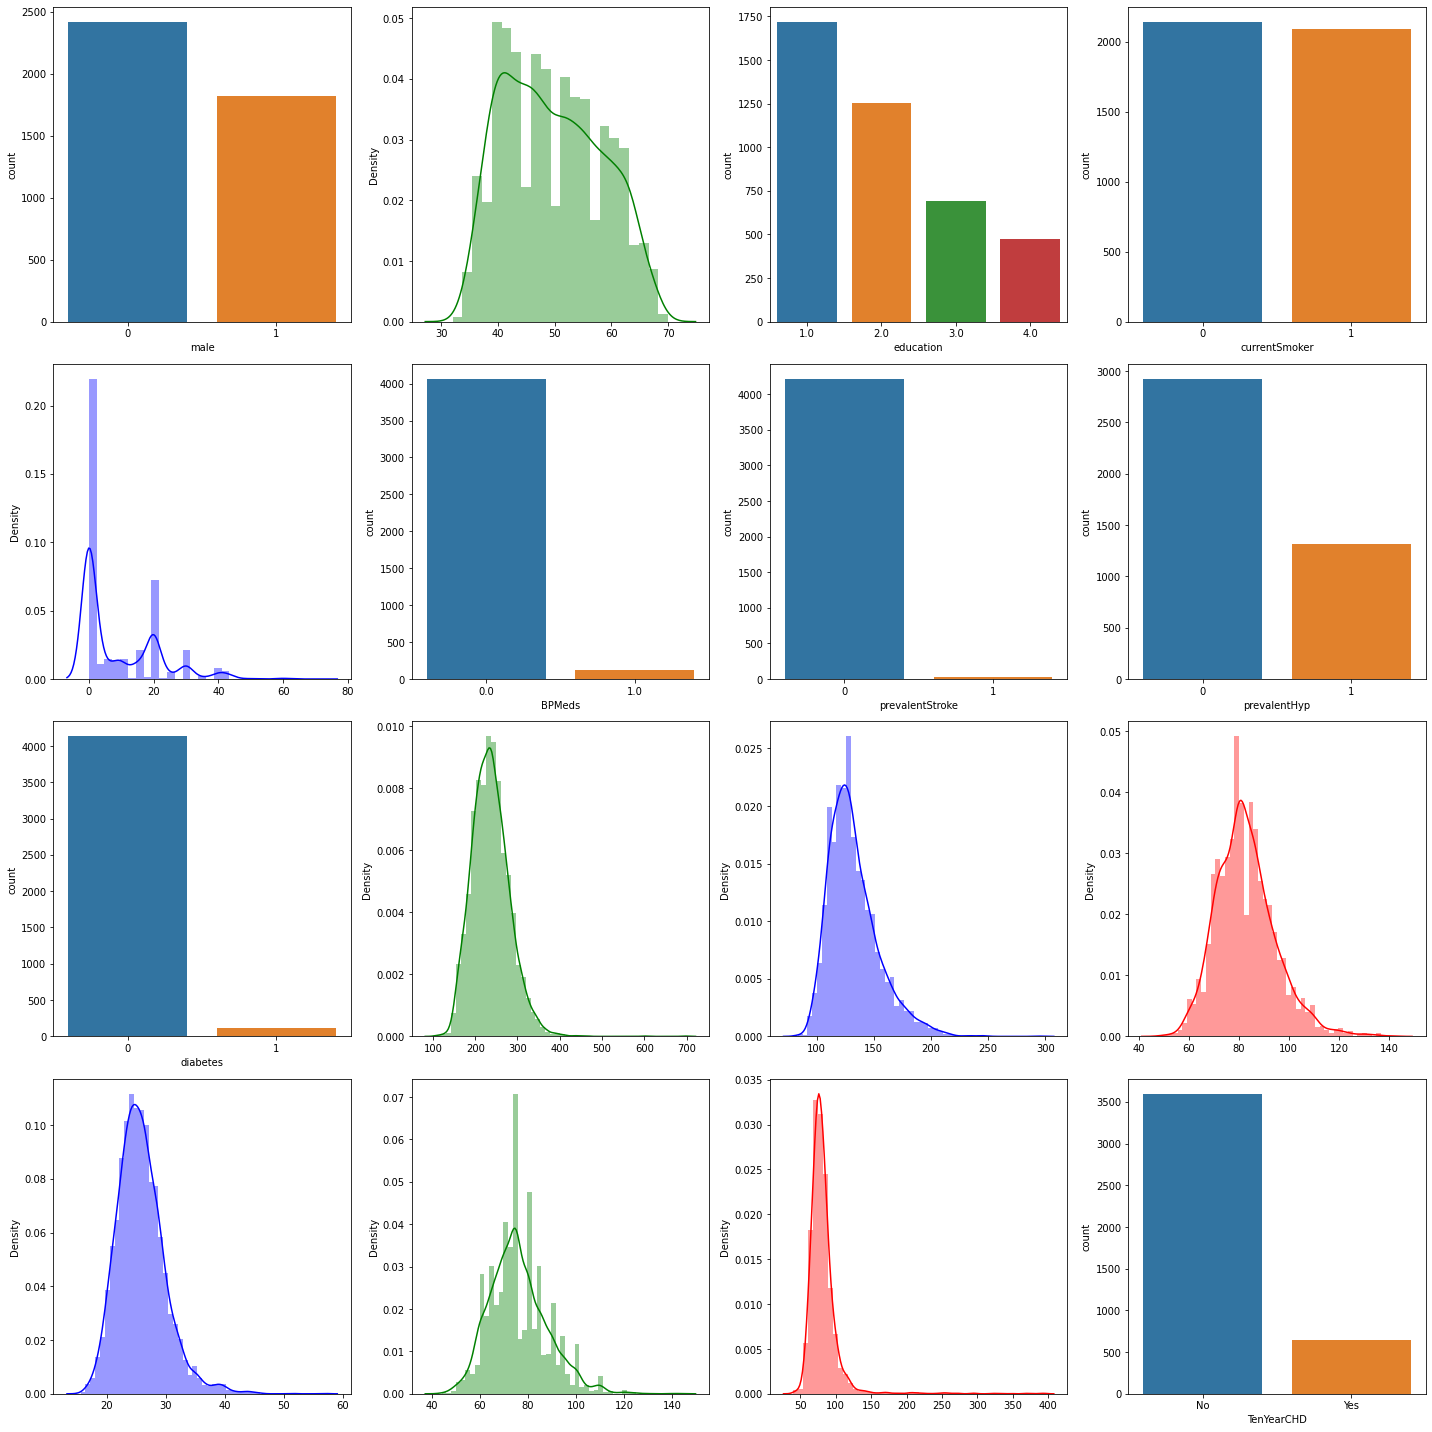

In [97]:
univariate(dfp)

#### Bivariate Analysis

In [98]:
def bivariate(df, y = target_var, cols = 4, rows = 4):
    temp = not_to_plot[:]
    temp.append(y)
    fig=plt.figure(figsize=(25,20))

    for j, i in enumerate(df.columns):
        if df[y].dtype == 'float':
            if i in df.select_dtypes(['category']):
                if (i not in temp): 
                    ax=fig.add_subplot(rows,cols,j+1)
                    sns.boxplot(x = i, y = y, data = df)

            if i in df.select_dtypes(['float', 'int']):                
                if (i not in temp):      
                    ax=fig.add_subplot(rows,cols,j+1)       
                    sns.scatterplot(x = y, y = i, data = df)                  
            
        elif df[y].dtype == 'category':
            if i in df.select_dtypes(['category']):
                if (i not in temp):
                    ax=fig.add_subplot(rows,cols,j+1)
                    sns.countplot(x = i, hue = y, data = df)
                    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

            if i in df.select_dtypes(['float', 'int']):
                if (i not in temp):
                    ax=fig.add_subplot(rows,cols,j+1)
                    sns.boxplot(x = y, y = i, data = df)
    fig.tight_layout() 
    plt.show()

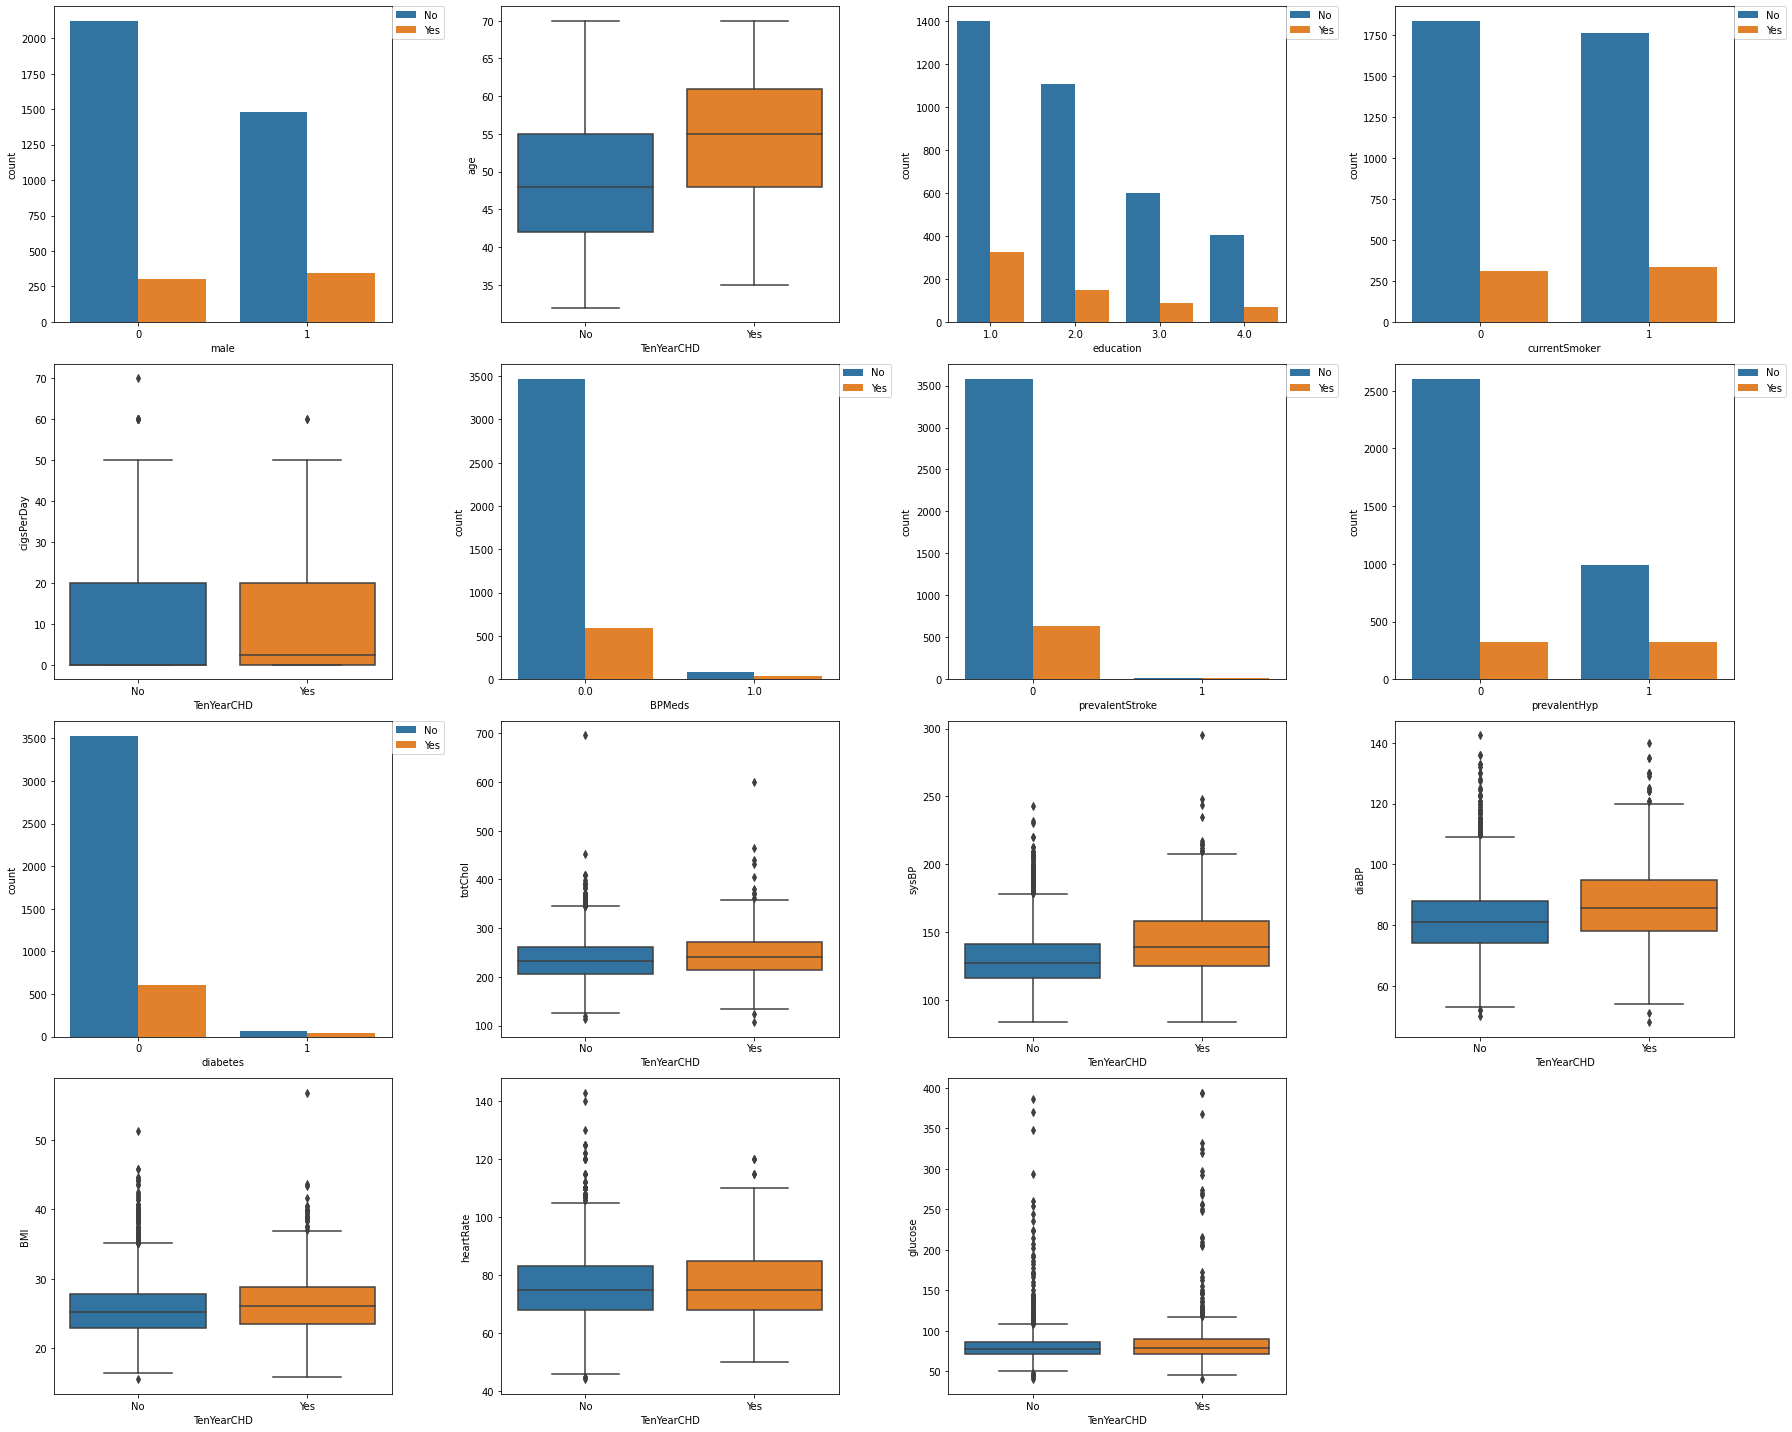

In [99]:
bivariate(dfp)

#### Missing Values

In [100]:
dfp.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [101]:
# % of all missing var
miss_df = pd.DataFrame(dfp.isnull().sum(), columns=['Miss_Values'])
for i in miss_df.index:
    val = miss_df._get_value(i, miss_df.columns[0]) 
    if val > 0:
        print(i, "% : ", val*100/dfp.shape[0])

education % :  2.4764150943396226
cigsPerDay % :  0.6839622641509434
BPMeds % :  1.25
totChol % :  1.179245283018868
BMI % :  0.4481132075471698
heartRate % :  0.02358490566037736
glucose % :  9.150943396226415


In [102]:
# Case 1: Drop All Null Values.
dfp.dropna(inplace=True)
dfp.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [103]:
dfp.TenYearCHD = le.fit_transform(dfp.TenYearCHD)
dfp.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [104]:
dfp.TenYearCHD.value_counts()

0    3101
1     557
Name: TenYearCHD, dtype: int64

#### Treating Imbalanced Dataset

Trying Oversampling using SMOTE

In [105]:
# Smote - Over Sampling
cols = dfp.columns
oversample = SMOTE(random_state = 2, sampling_strategy='minority')
x = dfp.loc[:, dfp.columns != 'TenYearCHD']
y = dfp.loc[:, dfp.columns == 'TenYearCHD']

x = x.values
y = y.values

x, y = oversample.fit_resample(x, y)

dfp = pd.concat([pd.DataFrame(x), pd.DataFrame(y)], axis=1)

dfp.columns = cols

dfp.TenYearCHD.value_counts()   # Oversampling Successful

0    3101
1    3101
Name: TenYearCHD, dtype: int64

In [106]:
# Can Also try this method

# x_train_sm, x_test_sm, y_train_sm, y_test_sm = split_data(dfp)

# x_train_sm = x_train_sm.values
# x_test_sm = x_test_sm.values
# y_train_sm = y_train_sm.values
# y_test_sm = y_test_sm.values

# pipeline = imbpipeline(
#     steps = [
#         ['smote', SMOTE(random_state=11)],
#         ['scaler', MinMaxScaler()],
#         ['classifier', LogisticRegression(random_state=11,max_iter=1000)]
#     ]
# )

# stratified_kfold = StratifiedKFold(n_splits=3,shuffle=True,random_state=11)

# param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100]}
# grid_search = GridSearchCV(estimator=pipeline,
#                            param_grid=param_grid,
#                            scoring='roc_auc',
#                            cv=stratified_kfold,
#                            n_jobs=4,
#                            error_score=0)
# # print(y_train_sm.isnull().sum())
# grid_search.fit(x_train_sm, y_train_sm)
# cv_score = grid_search.best_score_
# print(cv_score)

In [107]:
# Near Miss - Under Sampling

# nr = NearMiss() 
# x = dfp.loc[:, dfp.columns != 'TenYearCHD']
# y = dfp.loc[:, dfp.columns == 'TenYearCHD']
# X_near, Y_near= nr.fit_resample(x, y)
# dfp = pd.concat([X_near, Y_near], axis=1)

#### Model Building

##### 1. Logistic Regression

In [108]:
# Adding Constant variable

dfp_constant = ac(dfp)
dfp_constant.head()

,const,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,1.0,39.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,1.0,0.0,46.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1.0,1.0,48.0,1.0,1.0,20.0,0.0,0.0,0.0,0.0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,1.0,0.0,61.0,3.0,1.0,30.0,0.0,0.0,1.0,0.0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,1.0,0.0,46.0,3.0,1.0,23.0,0.0,0.0,0.0,0.0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [109]:
col = dfp_constant.columns[:-1]
model = sm.Logit(dfp.TenYearCHD,dfp_constant[col])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.599518
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 6202
Model:                          Logit   Df Residuals:                     6186
Method:                           MLE   Df Model:                           15
Date:                Mon, 11 Jul 2022   Pseudo R-squ.:                  0.1351
Time:                        18:29:57   Log-Likelihood:                -3718.2
converged:                       True   LL-Null:                       -4298.9
Covariance Type:            nonrobust   LLR p-value:                3.219e-238
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -6.8093      0.429    -15.881      0.000      -7.650      -5.969
male                0.6126      0.066      9.313      0.000       0.484       0.742
age                 0.0722      0.004     17.651      0.000       0.064       0.080
education          -0.0919      0.030     -3.084      0.002      -0.150      -0.033
currentSmoker       0.1899      0.099      1.918      0.055      -0.004       0.384
cigsPerDay          0.0123      0.004      2.969      0.003       0.004       0.020
BPMeds              0.4856      0.170      2.856      0.004       0.152       0.819
prevalentStroke     0.8286      0.392      2.113      0.035       0.060       1.597
prevalentHyp        0.2283      0.088      2.605      0.009       0.057       0.400
diabetes           -0.0098      0.229     -0.043      0.966      -0.460       0.440
totChol             0.0023      0.001      3.541      0.000       0.001       0.004
sysBP               0.0117      0.003      4.662      0.000       0.007       0.017
diaBP               0.0012      0.004      0.293      0.770      -0.007       0.009
BMI                 0.0070      0.008      0.881      0.378      -0.009       0.022
heartRate          -0.0034      0.003     -1.349      0.177      -0.008       0.002
glucose             0.0056      0.002      3.625      0.000       0.003       0.009
===================================================================================
"""

In [110]:
params_lg = {
    'penalty': ['l1', 'l2','elasticnet'],
    'tol': [0.1, 0.01],
    'C': [0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [10, 100],
    'multi_class': ['auto', 'ovr','multinomial'],
    'n_jobs': [3,4],
}

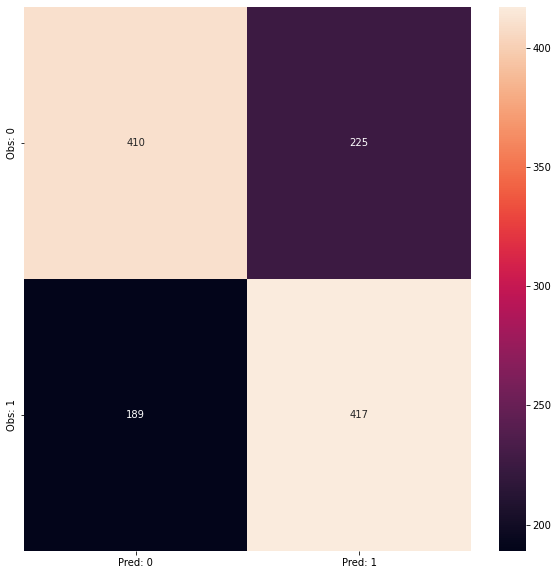

Sensitivity:  0.6881188118811881
Specificity:  0.6456692913385826
Precision:  0.6495327102803738
Accuracy:  0.6663980660757454


In [111]:
# Accuracy Before Back feature Elimination.

grid_search(LogisticRegression(), params_lg, dfp)

In [112]:
# Back feature Elimination for variables whose p-value is more than 0.05

def back_feat_elem(df, colm = col, y = dfp[target_var]):
    while len(colm) > 0:
        model = sm.Logit(y, df[colm])
        result = model.fit(disp= 0)
        largest_pvalue = round(result.pvalues, 3).nlargest(1)
        if largest_pvalue[0] < (0.05):
            return result
            break
        else:
            colm= colm.drop(largest_pvalue.index)

In [113]:
back_res = back_feat_elem(dfp_constant)
back_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 6202
Model:                          Logit   Df Residuals:                     6191
Method:                           MLE   Df Model:                           10
Date:                Mon, 11 Jul 2022   Pseudo R-squ.:                  0.1344
Time:                        18:30:42   Log-Likelihood:                -3721.3
converged:                       True   LL-Null:                       -4298.9
Covariance Type:            nonrobust   LLR p-value:                6.309e-242
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -6.7462      0.323    -20.856      0.000      -7.380      -6.112
male                0.6251      0.064      9.750      0.000       0.499       0.751
age                 0.0714      0.004     18.167      0.000       0.064       0.079
education          -0.0931      0.029     -3.164      0.002      -0.151      -0.035
cigsPerDay          0.0176      0.003      6.701      0.000       0.012       0.023
BPMeds              0.4793      0.170      2.823      0.005       0.147       0.812
prevalentStroke     0.8444      0.392      2.156      0.031       0.077       1.612
prevalentHyp        0.2270      0.086      2.636      0.008       0.058       0.396
totChol             0.0023      0.001      3.512      0.000       0.001       0.004
sysBP               0.0121      0.002      6.569      0.000       0.009       0.016
glucose             0.0055      0.001      4.898      0.000       0.003       0.008
===================================================================================
"""

In [114]:
new_x = dfp_constant[back_res.params.index]
new_x.drop(columns=['const'], axis=1, inplace=True)
new_y = dfp_constant.TenYearCHD
new_df = pd.concat([new_x,new_y], axis=1)
new_df.head()

,male,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,totChol,sysBP,glucose,TenYearCHD
0,1.0,39.0,4.0,0.0,0.0,0.0,0.0,195.0,106.0,77.0,0
1,0.0,46.0,2.0,0.0,0.0,0.0,0.0,250.0,121.0,76.0,0
2,1.0,48.0,1.0,20.0,0.0,0.0,0.0,245.0,127.5,70.0,0
3,0.0,61.0,3.0,30.0,0.0,0.0,1.0,225.0,150.0,103.0,1
4,0.0,46.0,3.0,23.0,0.0,0.0,0.0,285.0,130.0,85.0,0


Lowering the threshold from 0.5 to a lower value.

In [115]:
# for i in range(1,6):
#     y_pred_yes = logreg.predict_proba(x_test)
#     binarize = Binarizer(threshold=i/10)
#     y_pred2 = binarize.fit_transform(y_pred_yes)[:,1]

#     print(i/10)
#     cm_mat = confusion_matrix(y_test, y_pred2)
#     cm_data(cm_mat)

# 0.2 Threshlod looks good. Might try it later.

Comparing the Original DataFrame(dfp) and the New DataFrame(new_df) for all the models.

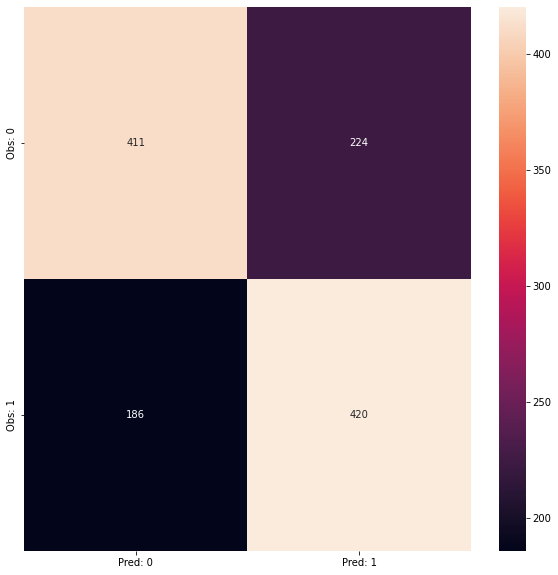

Sensitivity:  0.693069306930693
Specificity:  0.647244094488189
Precision:  0.6521739130434783
Accuracy:  0.669621273166801


In [116]:
grid_search(LogisticRegression(), params_lg, new_df)

The Accuracy is very low, So lets try other models.

##### 2: Decision Tree Classifier

In [117]:
new_df.TenYearCHD = new_df.TenYearCHD.astype('category')
new_df.TenYearCHD.dtype

CategoricalDtype(categories=[0, 1], ordered=False)

In [118]:
dfp.TenYearCHD = dfp.TenYearCHD.astype('category')
dfp.TenYearCHD.dtype

CategoricalDtype(categories=[0, 1], ordered=False)

In [119]:
params_dt = {
    'criterion': ['gini','entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 6, 9],
    'min_samples_leaf': [5, 8, 11],
    'max_features': ['sqrt', 'log2'],
}

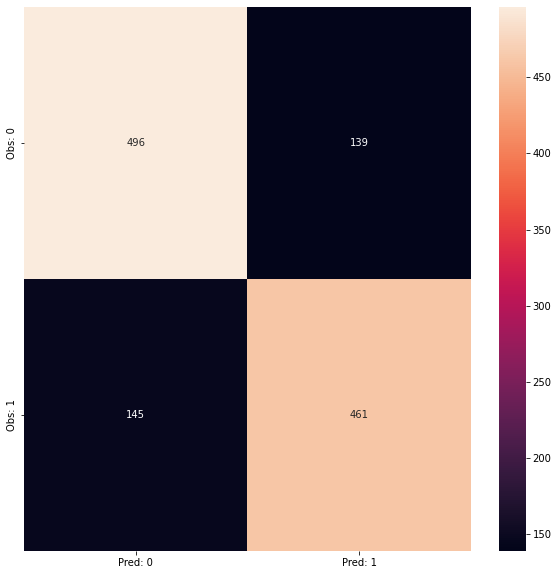

Sensitivity:  0.7607260726072608
Specificity:  0.7811023622047244
Precision:  0.7683333333333333
Accuracy:  0.7711522965350524


In [120]:
grid_search(DecisionTreeClassifier(), params_dt, dfp)

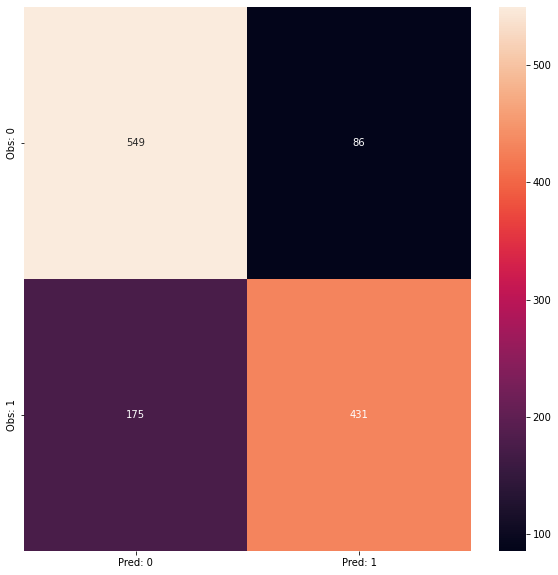

Sensitivity:  0.7112211221122112
Specificity:  0.8645669291338582
Precision:  0.8336557059961315
Accuracy:  0.7896857373086221


In [121]:
grid_search(DecisionTreeClassifier(), params_dt, new_df)

In Decision Tree, all the confusion matrix parameters are slighlty better for the new DataFrame. 
and a lot better than Logistic Regression.

##### 3: KNN Classification

In [122]:
params_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'n_jobs': [-1],
    'p':[0,1,2,i]
}

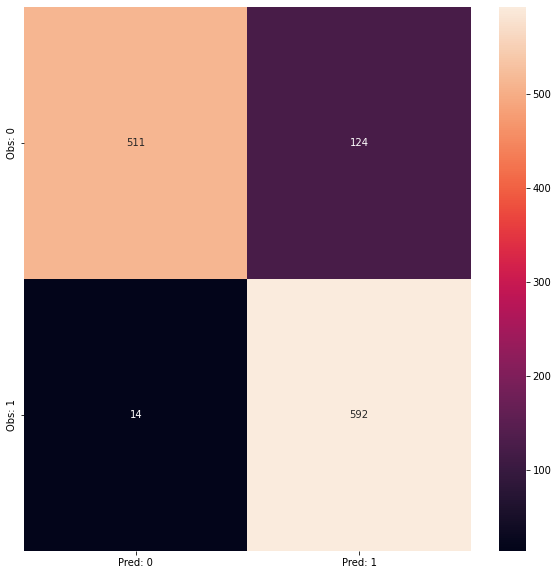

Sensitivity:  0.976897689768977
Specificity:  0.8047244094488188
Precision:  0.8268156424581006
Accuracy:  0.8887993553585818


In [123]:
grid_search(KNeighborsClassifier(), params=params_knn, df=dfp)

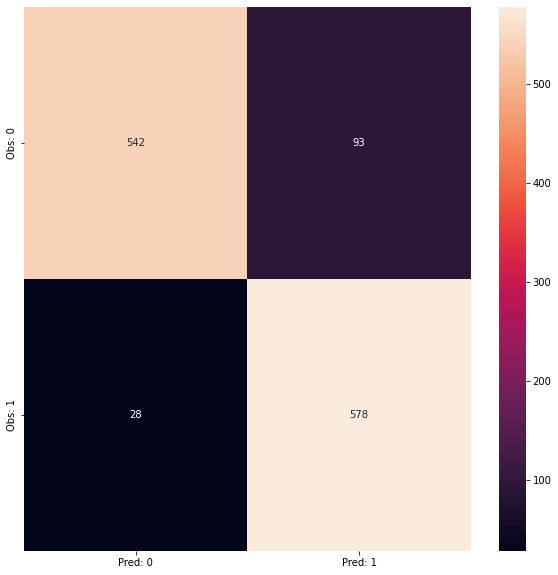

Sensitivity:  0.9537953795379538
Specificity:  0.8535433070866142
Precision:  0.8614008941877794
Accuracy:  0.9024979854955681


In [124]:
grid_search(KNeighborsClassifier(), params=params_knn, df=new_df)

##### 4: SVM

In [125]:
# To be done in the future

##### 5: Neural Networks

In [126]:
# To be done in the future

##### 6: Complex SVM

In [127]:
# To be done in the future

##### 7: Complex Neural Networks 

In [128]:
# To be done in the future

##### 8: Random Forest Classifier

Using GridSearchCV for Random Forest Classifier

In [129]:
rf_params = {
    'n_estimators': [10, 50, 100, 150, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 15, 20, 25, 40],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'oob_score': [True],
    'n_jobs': [3],
}

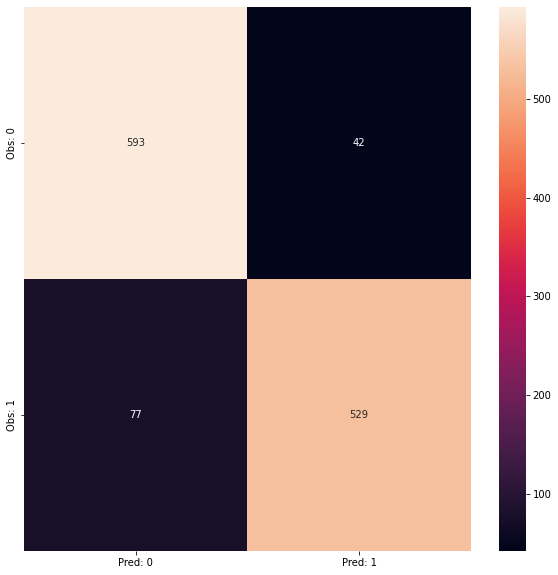

Sensitivity:  0.8729372937293729
Specificity:  0.9338582677165355
Precision:  0.9264448336252189
Accuracy:  0.9041095890410958


In [130]:
grid_search(RandomForestClassifier(), rf_params, dfp)

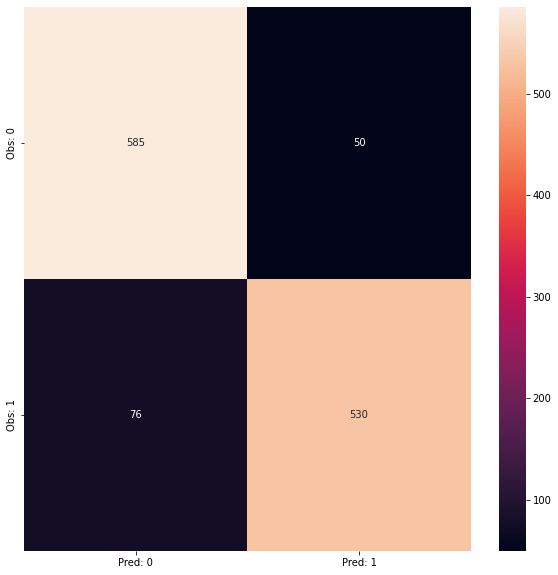

Sensitivity:  0.8745874587458746
Specificity:  0.9212598425196851
Precision:  0.9137931034482759
Accuracy:  0.8984689766317486


In [131]:
grid_search(RandomForestClassifier(), rf_params, new_df)

In Random Forest, the old DataFrame (dfp) is slightly better than the new one.

##### 9: Boosting